In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.autograd import grad

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import boda
from boda.generator import plot_tools
from boda.common import constants

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

from scipy import spatial
from scipy.cluster import hierarchy


In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20211113_021200 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


# Computing methods

In [3]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
                
        hook = self.model(hook).clamp(-2., 6.)
        
        if self.bias_cell is not None:
            hook = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                     - hook[...,self.bias_cell].mul(self.bias_alpha)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        return hook

In [4]:
@torch.no_grad()
def naive_mh_step(seq, energy_fn, temperature=1.0):
    
    assert len(seq.shape) == 3
    
    old_seq = seq.detach().clone()
    old_energy = energy_fn(old_seq)
    old_logits = old_seq * -115
    
    proposed_position = torch.randint(
        low=0, high=old_seq.shape[-1],
        size=(seq.shape[0],), 
        device=old_logits.device
    )
    updates = old_logits[torch.arange(seq.shape[0]), :, proposed_position].mul(-1)
    old_logits[torch.arange(seq.shape[0]), :, proposed_position] = updates
    proposal_dist = dist.OneHotCategorical(logits=-old_logits.permute(0,2,1)/temperature)
    
    new_seq = proposal_dist.sample().permute(0,2,1).detach().clone()
    new_energy = energy_fn(new_seq)
    
    u = torch.rand_like(old_energy).log()
    accept = u.le( (old_energy-new_energy)/temperature )
    
    sample = torch.stack([old_seq, new_seq], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    energy = torch.stack([old_energy, new_energy], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    
    return {'sample': sample.cpu(), 'energy': energy.cpu(), 'acceptance': accept.cpu()}

In [5]:
@torch.no_grad()
def naive_mh_step(seq, energy_fn, n_positions=1, temperature=1.0):
    
    assert len(seq.shape) == 3
    
    old_seq = seq.detach().clone()
    old_energy = energy_fn(old_seq)
    old_logits = old_seq * -115
    
    pos_shuffle = torch.argsort( torch.rand(seq.shape[0], seq.shape[-1]), dim=-1 )
    proposed_positions = pos_shuffle[:,:n_positions]
    batch_slicer = torch.arange(seq.shape[0]).view(-1,1)
    
    updates = old_logits[batch_slicer, :, proposed_positions].mul(-1)
    old_logits[batch_slicer, :, proposed_positions] = updates
    
    proposal_dist = dist.OneHotCategorical(logits=-old_logits.permute(0,2,1)/temperature)
    
    new_seq = proposal_dist.sample().permute(0,2,1).detach().clone()
    new_energy = energy_fn(new_seq)
    
    u = torch.rand_like(old_energy).log()
    accept = u.le( (old_energy-new_energy)/temperature )
    
    sample = torch.stack([old_seq, new_seq], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    energy = torch.stack([old_energy, new_energy], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    
    return {'sample': sample.cpu(), 'energy': energy.cpu(), 'acceptance': accept.cpu()}

In [6]:
def logits_from_grad_eval(seq, energy_fn):
    energy_ = energy_fn(seq)
    logits_ = grad(energy_.sum(), [seq])[0].detach()
    
    return energy_, logits_
    
def update_seq_and_reverse_key(seq, key):
    remember_grad = seq.requires_grad
    seq = seq.clone().detach()
    
    pos_key = key.remainder(seq.shape[-1])
    nt_key  = key.div(seq.shape[-1], rounding_mode='floor')
    old_nt  = seq[ torch.arange(seq.shape[0]), :,  pos_key].argmax(-1)
    old_key = nt_key.mul(200) + old_nt
    
    seq[ torch.arange(seq.shape[0]), :,  pos_key] = 0
    seq[ torch.arange(seq.shape[0]), nt_key,  pos_key] = 1
    
    seq.requires_grad = remember_grad
    
    return seq, old_key

In [7]:
def gradient_mh_step(seq, energy_fn, temperature=1.0):
    
    assert len(seq.shape) == 3
    old_seq = seq.detach().clone()
    old_seq.requires_grad = True
    
    old_energy, old_logits = logits_from_grad_eval(old_seq, energy_fn)    
    proposal_dist = dist.Categorical(logits=-old_logits.flatten(1,2)/temperature)
    proposal_key  = proposal_dist.sample()
    
    new_seq = seq.detach().clone()
    new_seq.requires_grad = True
    
    new_seq, reverse_key = update_seq_and_reverse_key(new_seq, proposal_key)    
    new_energy, new_logits = logits_from_grad_eval(new_seq, energy_fn)
    reverse_dist = dist.Categorical(logits=-new_logits.flatten(1,2)/temperature)
    
    forward_kenetic = -proposal_dist.log_prob(proposal_key)
    reverse_kenetic = -reverse_dist .log_prob(reverse_key)
    
    u = torch.rand_like(old_energy).log()
    accept = u.le( old_energy + forward_kenetic - new_energy - reverse_kenetic )
    
    sample = torch.stack([old_seq, new_seq], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    energy = torch.stack([old_energy, new_energy], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    
    return {'sample': sample.cpu(), 'energy': energy.cpu(), 'acceptance': accept.cpu()} 

# Plotting methods

In [8]:
def plot_evol(traj, energy, step=1):
    timesteps, tokens, pos_ct = traj.shape
    x = np.linspace(0.5,pos_ct+0.5,pos_ct+1)
    y = np.linspace(0.,timesteps,(timesteps//step)+1)
    x,y = np.meshgrid(x,y)
    z = traj.argmax(1).float().add(0.50).numpy()
    z = z[np.arange(0,timesteps,step)]
    z = np.flip(z, axis=0)
    cmap = mp.colors.ListedColormap(['g', 'y', 'r', 'b'])
    bounds = [0.,1.,2.,3.,4.]
    ticks = [0.5,1.5,2.5,3.5]
    norm = mp.colors.BoundaryNorm(bounds, cmap.N)
    fig, axes = plt.subplots(1, 2, figsize = (15,40), gridspec_kw={'width_ratios':[10,1]}, constrained_layout=True)
    ax = axes[0]
    p = ax.pcolormesh(x,y,z, cmap=cmap, norm = norm)
    ax.axis([x.min(),x.max(),y.min(),y.max()])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = fig.colorbar(p, ax=ax, boundaries = bounds, 
                        ticks = ticks, location='top')
    cbar.set_ticklabels(['A','G','T','C'])
    
    ax = axes[1]
    ax.plot(energy[np.arange(0,timesteps,step)],np.flip(np.arange(timesteps//step)))
    ax.set_ylim([0,timesteps//step])
    
    plt.show()
    return plt, ax

# K562

In [11]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=0, bias_alpha=1.)
step_count = 4000

test_insert = dist.OneHotCategorical(logits=torch.randn(512,200,4)).sample().permute(0,2,1)
test_insert = test_insert.cuda()

a = 1
b = 1
gamma = 0.501

mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for t in tqdm(range(step_count)):
    temp = a*((b+t)**-gamma)
    sample = naive_mh_step(test_insert.cuda(), my_energy, n_positions=3, temperature=temp)
    mcmc_run['samples'].append(sample['sample'])
    mcmc_run['energies'].append(sample['energy'])
    mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

mcmc_run['acceptances'].sum(0)

100%|██████████| 4000/4000 [02:23<00:00, 27.95it/s]


tensor([297, 310, 399, 342, 354, 422, 318, 383, 291, 377, 276, 349, 338, 328,
        434, 325, 330, 319, 518, 317, 400, 325, 409, 286, 269, 292, 362, 334,
        395, 296, 348, 417, 286, 292, 321, 290, 377, 429, 296, 334, 344, 399,
        384, 278, 319, 267, 366, 298, 312, 439, 493, 483, 382, 395, 305, 330,
        344, 455, 341, 318, 302, 249, 319, 399, 290, 302, 419, 377, 321, 383,
        285, 312, 315, 338, 355, 310, 335, 380, 376, 281, 346, 311, 297, 365,
        365, 381, 409, 390, 331, 341, 431, 359, 334, 343, 415, 336, 365, 231,
        417, 308, 357, 368, 347, 412, 298, 330, 328, 334, 403, 354, 371, 261,
        456, 376, 363, 346, 361, 328, 334, 354, 351, 331, 306, 394, 298, 358,
        339, 254, 353, 327, 372, 347, 345, 335, 380, 356, 314, 346, 508, 401,
        422, 376, 303, 439, 366, 258, 329, 403, 302, 299, 363, 367, 403, 352,
        455, 422, 359, 334, 387, 330, 291, 282, 322, 380, 350, 409, 293, 339,
        290, 308, 278, 271, 363, 373, 317, 317, 376, 383, 376, 2

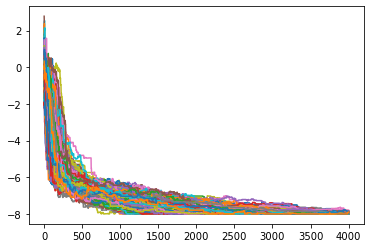

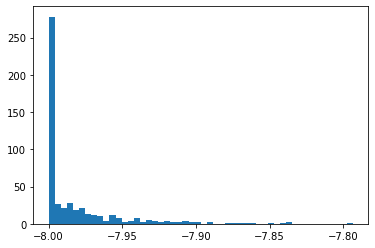

In [12]:
for i in range(test_insert.shape[0]):
    plt.plot(torch.arange(step_count),mcmc_run['energies'][:,i])
plt.show()

plt.hist( mcmc_run['energies'][-1].flatten().numpy(), bins=50 )
plt.show()

In [12]:
def plot_evol(traj, energy, step=1):
    timesteps, tokens, pos_ct = traj.shape
    x = np.linspace(0.5,pos_ct+0.5,pos_ct+1)
    y = np.linspace(0.,timesteps,(timesteps//step)+1)
    x,y = np.meshgrid(x,y)
    z = traj.argmax(1).float().add(0.50).numpy()
    z = z[np.arange(0,timesteps,step)]
    z = np.flip(z, axis=0)
    cmap = mp.colors.ListedColormap(['g', 'y', 'r', 'b'])
    bounds = [0.,1.,2.,3.,4.]
    ticks = [0.5,1.5,2.5,3.5]
    norm = mp.colors.BoundaryNorm(bounds, cmap.N)
    fig, axes = plt.subplots(1, 2, figsize = (15,40), gridspec_kw={'width_ratios':[10,1]}, constrained_layout=True)
    ax = axes[0]
    p = ax.pcolormesh(x,y,z, cmap=cmap, norm = norm)
    ax.axis([x.min(),x.max(),y.min(),y.max()])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = fig.colorbar(p, ax=ax, boundaries = bounds, 
                        ticks = ticks, location='top')
    cbar.set_ticklabels(['A','G','T','C'])
    
    ax = axes[1]
    ax.plot(energy[np.arange(0,timesteps,step)],np.flip(np.arange(timesteps//step)))
    ax.set_ylim([0,timesteps//step])
    
    plt.show()
    return plt, ax

201


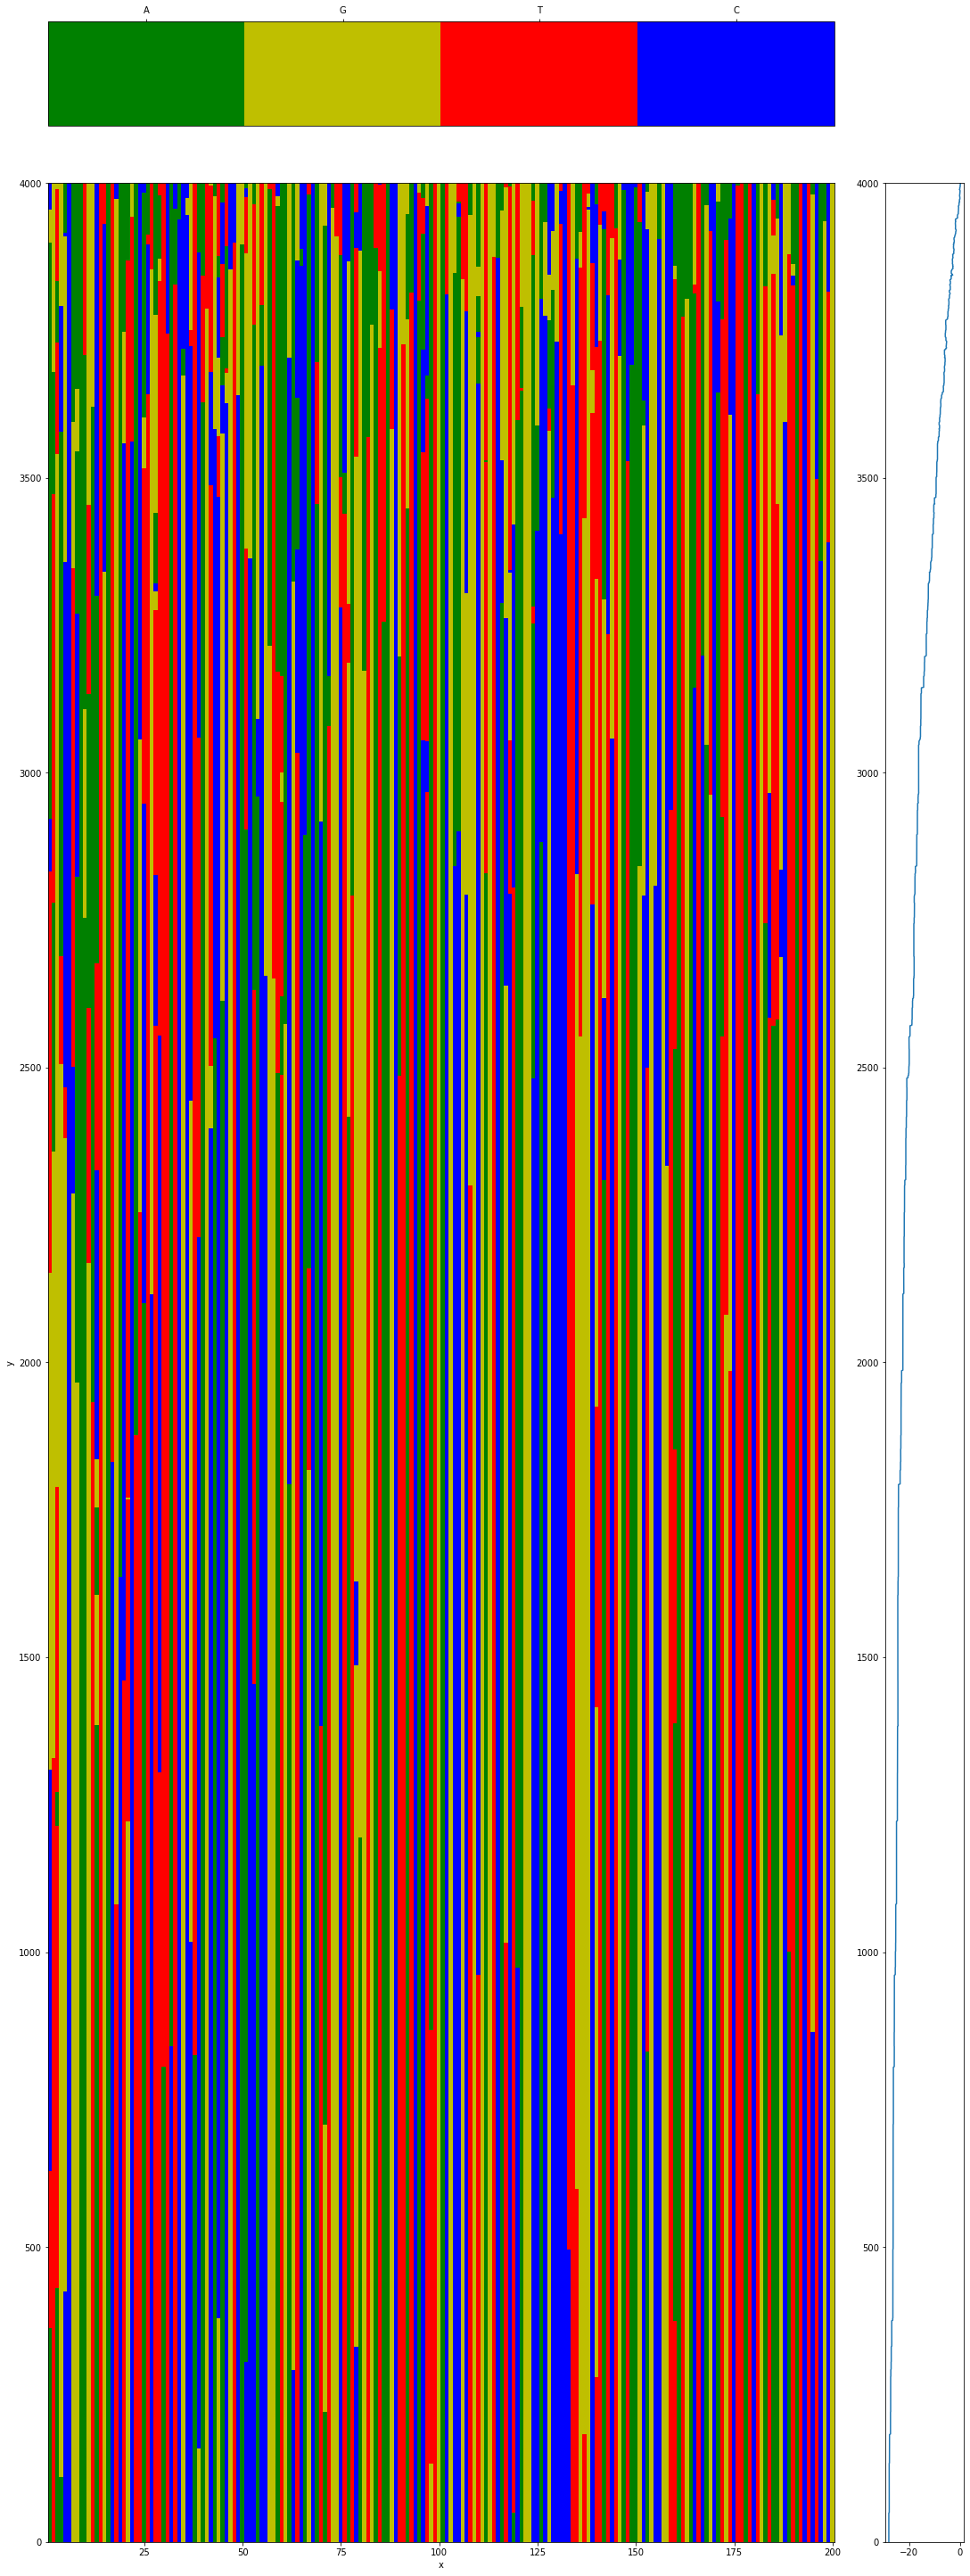

In [14]:
best_traj = mcmc_run['energies'][-1].argmin().item()
print(best_traj)
_ = plot_evol(mcmc_run['samples'][:,best_traj,:,:],mcmc_run['energies'][:,best_traj])

In [15]:
for seq_id in range(mcmc_run['samples'].shape[1]):
    print(f'>seq_{seq_id}')
    final_seq = mcmc_run['samples'][-1][seq_id].argmax(dim=0)
    print("".join([ constants.STANDARD_NT[x] for x in final_seq ]))

>seq_0
TGTGGCCTTATCTGATTACGCAAGACTAATCTGCTTGGCCACGCCTCACACTTGTCAGTAGAGATAAGATAACCCGCCCCTCCCCGGAAGTGACAGCCGGCGCCTCAAGATAACGTCGTCACTCTTATCTGCTGCCGGCAGGGGGCGCTGTCATGTTATCGATAGATAAGAGCTATCTTGGGCGGAGCTGCGCAGATAGC
>seq_1
GATAAGAAAATTGCTGAGTCATCCTCTTATCGAAAACAACAGATGTCTTATCACCCTAACGCAGTGACTCGTTATCTTATCAGTTCACTGCAGTCAATGACGTCACAGGGCCACGCCCCCTTGCGGTGCCGTTTAGATAAGGCGATGACTCATCATCTTGCGACGCCTGCTTATCTTGATAAGCAGACGGCCAATGACGT
>seq_2
GTAACTTTGAGGCCCCGCCCCCTTGATGACTCAGCAGTGGGCGTGTCTTATCTCCAGAAACCAGACAGCTGCTGTTTACGATATCAGTCACAGTCAGTAGTTGTTAGATAAGCAGATCCGGAAGTCGATGACTCAGCAGGGCGTGACTTATCTCCTCGAAACAGACACGCCCCTTATCTGTTTCAACAGATAAGATAGTG
>seq_3
TTATCTCCTCCCACCAGTGGGGCCGCCCCCGCATGATGACTCAGCACTTATCGAGCTGCCACATCGAGATAAGAAGCGGAAGTGACTAACCTTATCACGCTCTGGCGCCGCCGATAACAGATTATGACTCATCGGGTGTGACCGCCGGTCATGACTGATAAGAACTTCCGCTAACAGCCGGCCTTATCTGATAAGAACCG
>seq_4
GCGCACTAAAATGGGCGTCACCCAAATTTGCATATCGTCGCAGCCGTAAGCGTCTTATCGGAGTTGAACACTGACGCCACATGGTTTCAACAGATAAGGAGCAAGGGGCGGGGTTCCTGGAAAAGTGCTGACTCATCGTGGGTGTGGTCATATCTGATAAC

In [9]:
pentamer_scan = boda.common.utils.KmerFilter(k=4)
kmer_content  = pentamer_scan( mcmc_run['samples'][-1] ).max(dim=-1).values

In [10]:
def jaccard_index(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            inter = torch.logical_and(x_batch,y_batch).sum(-1)
            union = torch.logical_or(x_batch,y_batch).sum(-1)
            ji = inter / union
            row.append(ji.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

def euclidean_distance(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            dist  = (x_batch - y_batch).pow(2).sum(-1).pow(0.5)
            row.append(dist.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

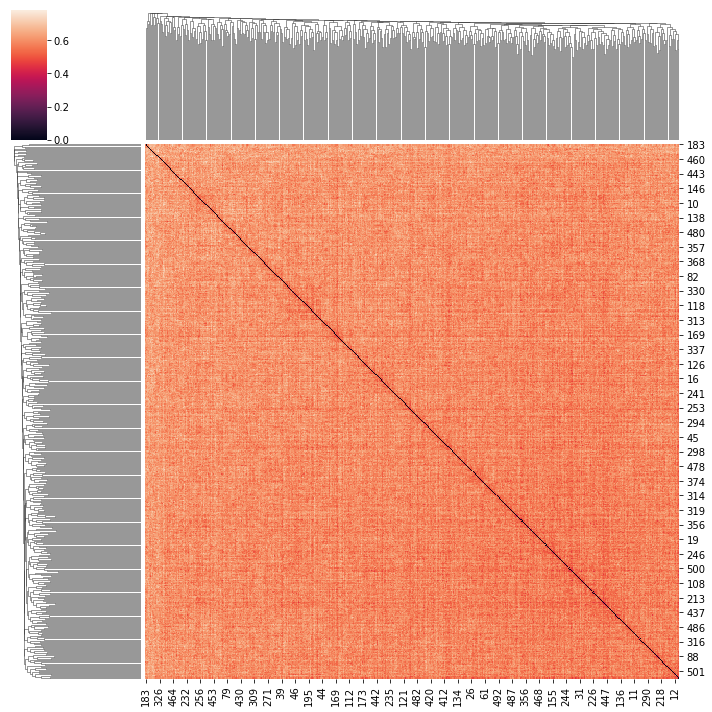

In [11]:
jac_res = jaccard_index(kmer_content, kmer_content, max_batch_size=512, dtype=torch.half)

DF_dism = 1 - jac_res.cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [12]:
with open('K562_tau_mh_samples.pkl', 'wb') as f:
    pickle.dump(mcmc_run['samples'][-1].cpu().numpy(), file=f)

# HepG2

In [9]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=1, bias_alpha=1.)
step_count = 5000

test_insert = dist.OneHotCategorical(logits=torch.randn(512,200,4)).sample().permute(0,2,1)
test_insert = test_insert.cuda()

a = 1
b = 1
gamma = 0.501

mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for t in tqdm(range(step_count)):
    temp = a*((b+t)**-gamma)
    sample = naive_mh_step(test_insert.cuda(), my_energy, n_positions=3, temperature=temp)
    mcmc_run['samples'].append(sample['sample'])
    mcmc_run['energies'].append(sample['energy'])
    mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

mcmc_run['acceptances'].sum(0)

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 5000/5000 [03:10<00:00, 26.19it/s]


tensor([207, 244, 244, 208, 198, 240, 256, 188, 194, 245, 254, 265, 233, 174,
        292, 254, 161, 252, 202, 292, 262, 292, 202, 257, 207, 256, 205, 236,
        203, 201, 204, 211, 274, 222, 202, 215, 235, 199, 286, 200, 271, 204,
        233, 290, 223, 260, 271, 272, 213, 230, 244, 253, 181, 247, 221, 198,
        193, 225, 239, 245, 200, 221, 262, 276, 251, 156, 229, 236, 236, 285,
        371, 236, 215, 181, 219, 201, 222, 203, 215, 225, 268, 220, 267, 206,
        197, 257, 271, 261, 178, 211, 246, 244, 238, 193, 225, 227, 255, 238,
        269, 194, 195, 247, 168, 259, 263, 337, 303, 217, 223, 274, 216, 219,
        242, 242, 235, 217, 248, 216, 227, 220, 205, 202, 222, 258, 231, 278,
        205, 247, 215, 315, 266, 270, 221, 203, 234, 268, 281, 198, 220, 175,
        207, 159, 176, 250, 211, 256, 304, 204, 224, 230, 217, 247, 165, 175,
        261, 207, 238, 243, 232, 240, 195, 258, 277, 252, 303, 235, 194, 308,
        258, 257, 187, 222, 157, 146, 214, 232, 251, 241, 221, 1

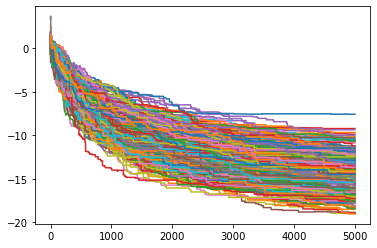

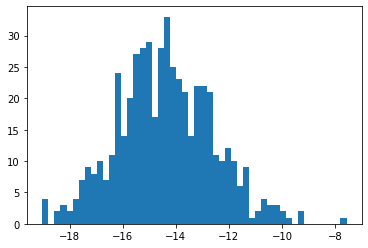

In [10]:
for i in range(test_insert.shape[0]):
    plt.plot(torch.arange(step_count),mcmc_run['energies'][:,i])
plt.show()

plt.hist( mcmc_run['energies'][-1].flatten().numpy(), bins=50 )
plt.show()

261


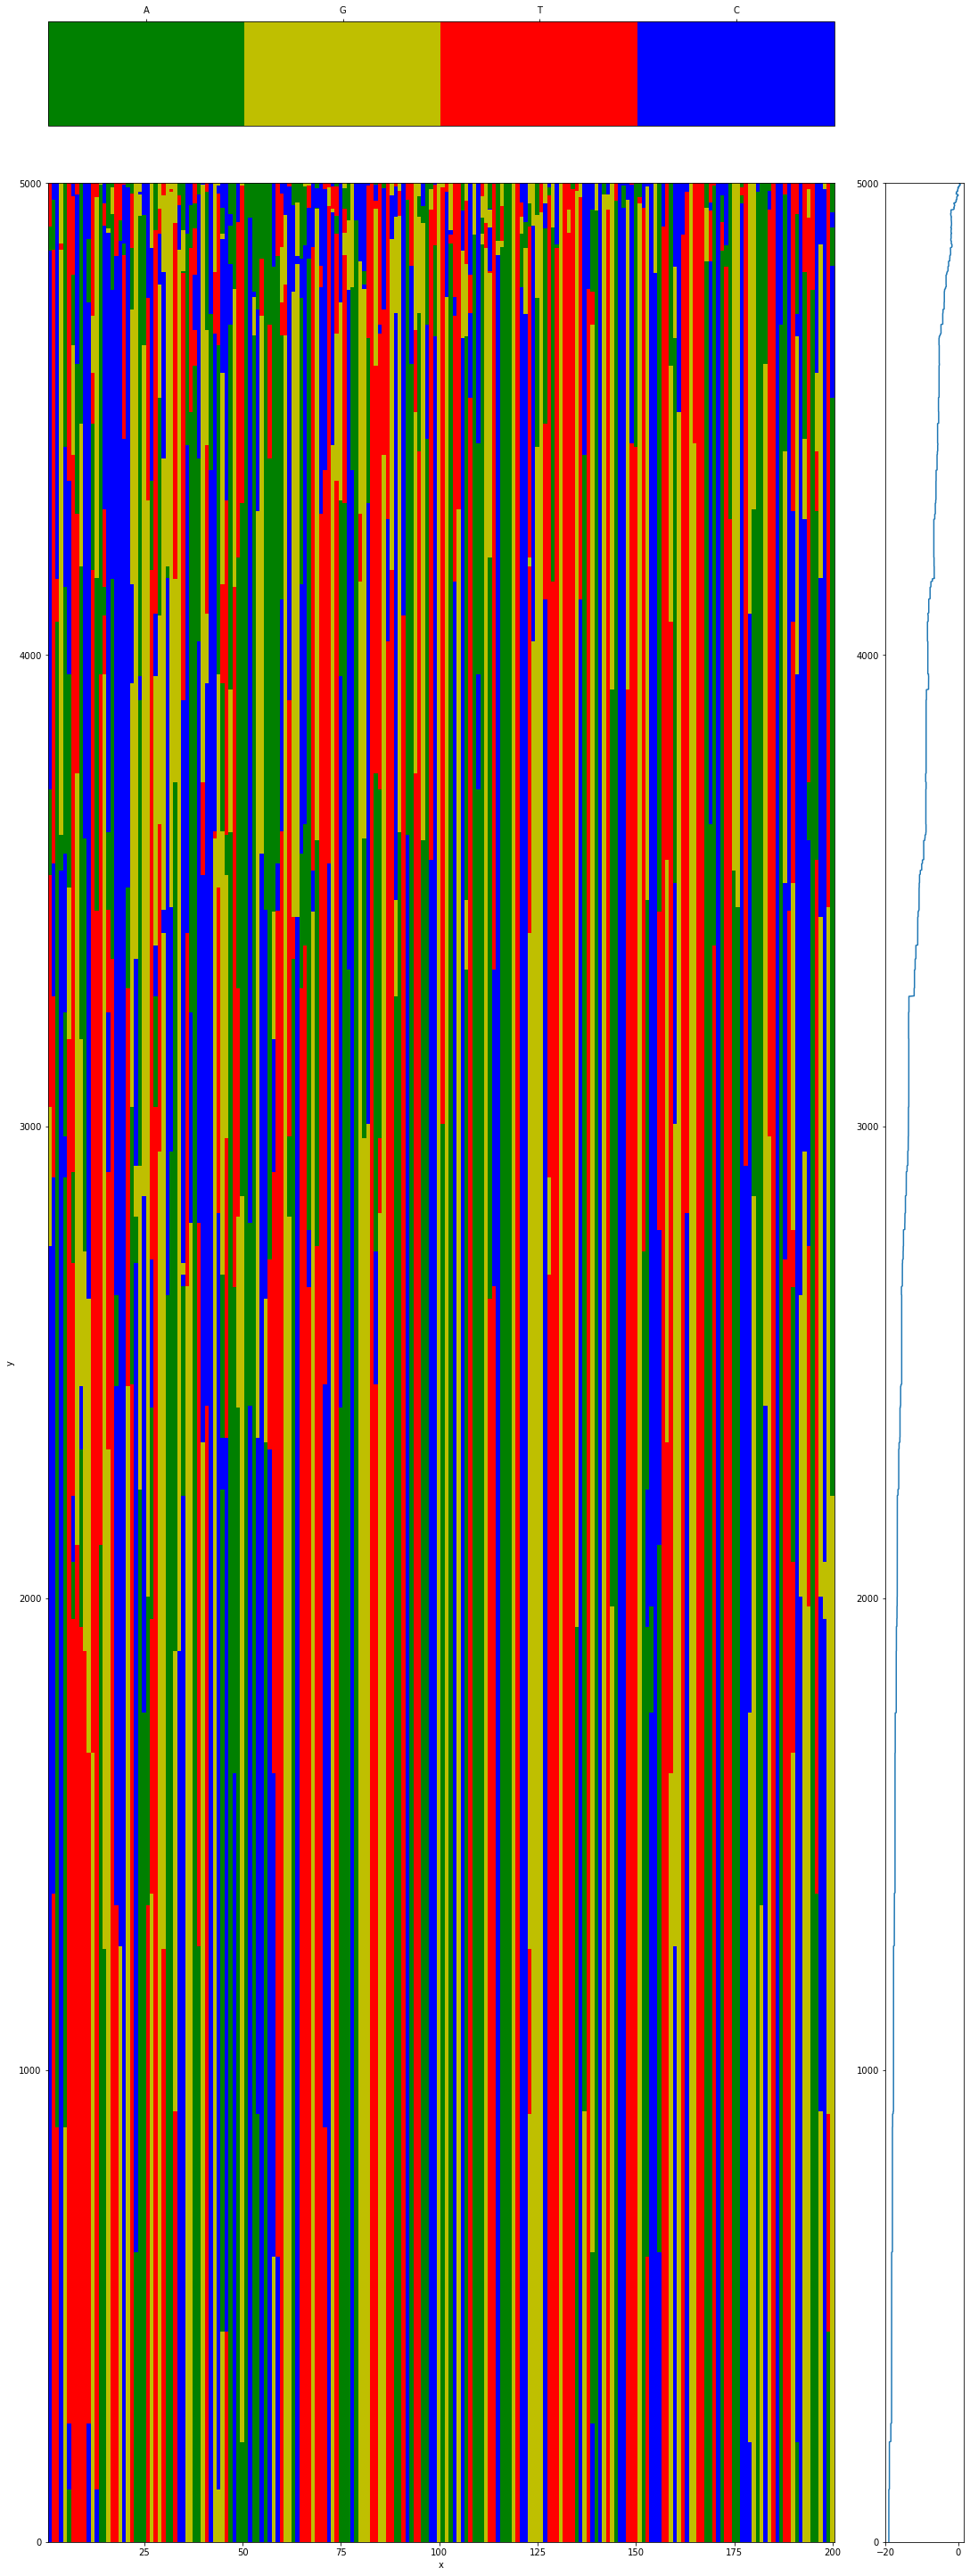

In [11]:
best_traj = mcmc_run['energies'][-1].argmin().item()
print(best_traj)
_ = plot_evol(mcmc_run['samples'][:,best_traj,:,:],mcmc_run['energies'][:,best_traj])

In [12]:
for seq_id in range(mcmc_run['samples'].shape[1]):
    print(f'>seq_{seq_id}')
    final_seq = mcmc_run['samples'][-1][seq_id].argmax(dim=0)
    print("".join([ constants.STANDARD_NT[x] for x in final_seq ]))

>seq_0
CCCCAGCTTGACTAGTGAGACTAGATCAAGGTCAATGATTTCGCATACCTTGCCCTGCAAAAATCACGGTCATCCGCGATGAGTCACCACACAGGTATGTATGAATCACCAGCGTACAAAGGTCAAAGTCGCCTGCACAGTAAGATCAAAGTCCAGCTTGCTGAGATTGCGCATTTCCGGTCACCTTGTGCCGGAATACA
>seq_1
TTGCCCCCGGCCTTGCATGGCCATAGATCTAAATCCATGCTTGTCCATGATTTCGCAAAGCGTAAGCACAAAGGAATTCGTGATTCATCACCTTTGCCCTGCGAGCCATGGGACGGCCGGGCGATGCTGACACAGATCAAAGGTCAGCGTAGTTGTAATGAGTCCGGGTGTGTCACAAATCTGGTCGGTTAATCATTAAC
>seq_2
CAGTCCCAGGGTGCAGCAAGGTCAATCATTGGTTGTTTACCTATGAGGTCAACCTATTACGGCCTCCGCCGCCTGCCCGGACGAGTTAATCATTAACCCACGATCATTGTGCCCTTTGTTTACATTCCAGACCAAAGTCCAGACTTTGTCACTCTAAACAAACGCTCTGATTGTGTAATCAGAGCCTGGTTAATGATTAA
>seq_3
TTTACAGCAAAAGAGTAGATTTGTACAAGATCAAAGTCCATGGACTTTGAACTGTTCGAGTTAATGATTAACTAGCTCTGATGCAGCATACCAGCTCGTTAATCATTAACCCACATGGACCTTTGACCTTCGGACTGTGCTGCCGTGATTTGGCATTTGATCTAACAGAGTGACGTGATTGTTTAAGGTGGCTTCTAAAT
>seq_4
GGGTCGAGTTCAAGAGCTAGTGGGGACCTTTGAATCCTAGTGATGTTAATGATTCACCTATGAGTCACGGACGGCATGTGTAAACATGACGTGCTCAACACTGTGGACTTTGTACCTTCCGTTAGGTTAATGATTAACTGTTTACTGTTTGCCGAGGTGCG

In [9]:
pentamer_scan = boda.common.utils.KmerFilter(k=4)
kmer_content  = pentamer_scan( mcmc_run['samples'][-1] ).max(dim=-1).values

In [10]:
def jaccard_index(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            inter = torch.logical_and(x_batch,y_batch).sum(-1)
            union = torch.logical_or(x_batch,y_batch).sum(-1)
            ji = inter / union
            row.append(ji.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

def euclidean_distance(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            dist  = (x_batch - y_batch).pow(2).sum(-1).pow(0.5)
            row.append(dist.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

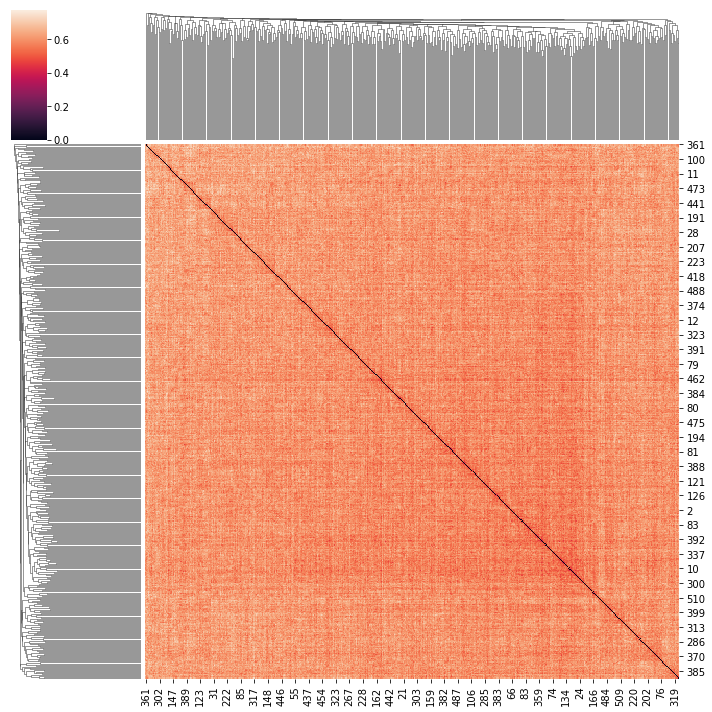

In [11]:
jac_res = jaccard_index(kmer_content, kmer_content, max_batch_size=512, dtype=torch.half)

DF_dism = 1 - jac_res.cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [12]:
with open('HepG2_tau_mh_samples.pkl', 'wb') as f:
    pickle.dump(mcmc_run['samples'][-1].cpu().numpy(), file=f)

# SK-N-SH

In [6]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=2, bias_alpha=1.)
step_count = 5000

test_insert = dist.OneHotCategorical(logits=torch.randn(512,200,4)).sample().permute(0,2,1)
test_insert = test_insert.cuda()

a = 1
b = 1
gamma = 0.501

mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for t in tqdm(range(step_count)):
    temp = a*((b+t)**-gamma)
    sample = naive_mh_step(test_insert.cuda(), my_energy, n_positions=3, temperature=temp)
    mcmc_run['samples'].append(sample['sample'])
    mcmc_run['energies'].append(sample['energy'])
    mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

mcmc_run['acceptances'].sum(0)

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 5000/5000 [03:07<00:00, 26.69it/s]


tensor([159, 240, 182, 159, 240, 284, 227, 260, 223, 259, 209, 226, 281, 215,
        262, 253, 177, 212, 193, 217, 175, 179, 142, 187, 193, 225, 159, 227,
        252, 236, 209, 223, 220, 246, 208, 185, 174, 189, 228, 172, 136, 197,
        168, 208, 182, 287, 154, 210, 215, 215, 222, 183, 177, 223, 257, 250,
        193, 226, 238, 270, 232, 188, 175, 219, 158, 216, 241, 253, 227, 203,
        231, 206, 165, 154, 203, 235, 232, 202, 255, 172, 189, 236, 213, 213,
        264, 226, 242, 164, 164, 203, 231, 242, 171, 252, 184, 272, 161, 245,
        223, 199, 272, 246, 236, 198, 276, 214, 184, 186, 208, 212, 251, 251,
        253, 233, 208, 205, 199, 191, 243, 211, 165, 243, 192, 181, 254, 236,
        188, 212, 206, 264, 171, 247, 230, 215, 242, 250, 255, 196, 186, 230,
        263, 162, 182, 221, 222, 242, 196, 250, 180, 191, 214, 249, 171, 244,
        237, 239, 186, 214, 218, 202, 252, 237, 192, 205, 163, 233, 161, 261,
        234, 215, 177, 171, 192, 184, 220, 270, 213, 239, 185, 2

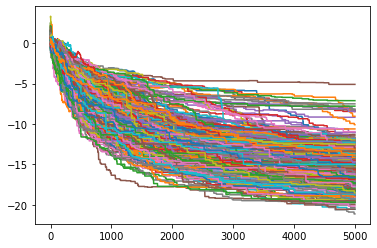

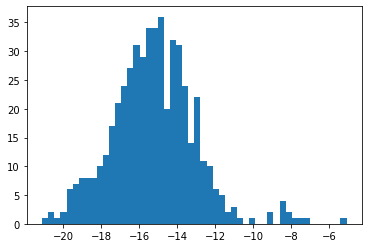

In [7]:
for i in range(test_insert.shape[0]):
    plt.plot(torch.arange(step_count),mcmc_run['energies'][:,i])
plt.show()

plt.hist( mcmc_run['energies'][-1].flatten().numpy(), bins=50 )
plt.show()

In [8]:
for seq_id in range(mcmc_run['samples'].shape[1]):
    print(f'>seq_{seq_id}')
    final_seq = mcmc_run['samples'][-1][seq_id].argmax(dim=0)
    print("".join([ constants.STANDARD_NT[x] for x in final_seq ]))

>seq_0
GACTACGTCTCGAGAAATCGGGTCGCGGAGCGACGAGAACCGGAAGTGACGTCACTTCCGGAGTTATAGCAGTAAGAGCAGAGGAATCCTGGGCATCCCCAAAGGATTCTTGTATTTCCCGTATTACGTTCGATATTTAACATCCGCTGACGAAACCGGAAGTAGCTTGTTCCGGCATCATGCCTACATGTCTGGGCAGG
>seq_1
CGAAACCCGGATATGCATCAGCTGAGTCACGAAAGAGTTACGTCACGGGGTAGCCATCTTGGGCATGACTCATCGATTCCGACTACCGGAAATTTCCAAGACTGCTCTACTACTGGTTATAGTAGTTTCGGTTTCGTCATCGGATTAGTCCCTGGAACCGGAAATAATCGGAAATTCTAAGCACTGCGATGCGCCTCAGT
>seq_2
ATCGAAGCCAACCTGACCCATCCCTAAGGAGCGGAAGCGACTGGGTGGACCATACGTAACGGAATTACGTAACCGGATGAGTTCGATCCTCCCAAATTGCTACGTCACTTCCGGCGCCGGATATTGGGACTTGTCTTGGCATATCCGTTTTGCCGGACATGCGCATACAAGAAGTGCAGTACGCGTTCAAGCTGCGTGAT
>seq_3
GAATGATTCGTCGCCGGAAATGACGTACTTCCGTTTTGGATGACGTCATCGATCGCCGGGGACGCATCTTAGCGGATTTCCGCCCTGGCATGCCCGGACATGCCCAGGCGCTATGATTAGTCACTTAGTTTCGAAATTAGTTTCATTTTCACTTGGCAAGAGTTACGTCTTCCCGGAATTCCAGTGTGGTTTCGGTTTCT
>seq_4
TCATTTCCGTTTCGTTTCATGACGCAACTTCCGGAAGTGCTACGTAATCAGGAAAATTCCTAACACGTGAGAACTAGTTTCCGCCATCTTCCGGAAGTAGAGATCTTCGTCAGGAATCCGGAAGTTTCCGACCCGACCGGAAGCGGATGTGAGTATTAATA

In [9]:
pentamer_scan = boda.common.utils.KmerFilter(k=5)
kmer_content  = pentamer_scan( mcmc_run['samples'][-1] ).max(dim=-1).values

In [10]:
def jaccard_index(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            inter = torch.logical_and(x_batch,y_batch).sum(-1)
            union = torch.logical_or(x_batch,y_batch).sum(-1)
            ji = inter / union
            row.append(ji.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

def euclidean_distance(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            dist  = (x_batch - y_batch).pow(2).sum(-1).pow(0.5)
            row.append(dist.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

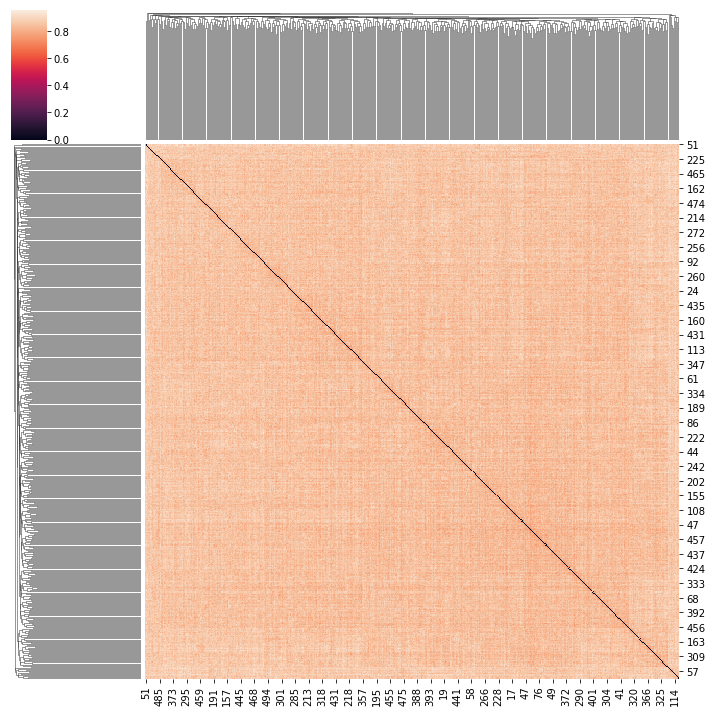

In [11]:
jac_res = jaccard_index(kmer_content, kmer_content, max_batch_size=512, dtype=torch.half)

DF_dism = 1 - jac_res.cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [12]:
np.median( DF_dism )

0.852

In [12]:
with open('SKNSH_tau_mh_samples.pkl', 'wb') as f:
    pickle.dump(mcmc_run['samples'][-1].cpu().numpy(), file=f)

# K562, GBMH

In [ ]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=0, bias_alpha=1.)
step_count = 10000

test_insert = dist.OneHotCategorical(logits=torch.randn(512,200,4)).sample().permute(0,2,1)
test_insert = test_insert.cuda()

a = 4
b = 1
gamma = 0.501

mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for t in tqdm(range(step_count)):
    temp = a*((b+(t//5))**-gamma)
    #temp = 1.
    sample = gradient_mh_step(test_insert.cuda(), my_energy, temperature=temp)
    if t % 2 == 0:
        mcmc_run['samples'].append(sample['sample'])
        mcmc_run['energies'].append(sample['energy'])
        mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

mcmc_run['acceptances'].sum(0)

100%|██████████| 10000/10000 [18:17<00:00,  9.12it/s]


In [ ]:
for i in range(test_insert.shape[0]):
    plt.plot(torch.arange(step_count),mcmc_run['energies'][:,i])
plt.show()

plt.hist( mcmc_run['energies'][-1].flatten().numpy(), bins=50 )
plt.show()

In [8]:
for seq_id in range(mcmc_run['samples'].shape[1]):
    print(f'>seq_{seq_id}')
    final_seq = mcmc_run['samples'][-1][seq_id].argmax(dim=0)
    print("".join([ constants.STANDARD_NT[x] for x in final_seq ]))

>seq_0
CGATAAGGCTTATCAATAGTGACGTCATGCTGTTGACCGGAGATAAGCGTGTTATCTCGCCACTTCCGGCCTGAGTCAGATAAGCACTATCCGACATGACTCATCACTTCCGGACCGGCGCCTTATCGATAAGGCGCCAGTAGGCGGAGCCGGGGGAGGCACGCCCCCTTGTGGTGATAGGATAACTCGAGATAAGCAAA
>seq_1
TTGACCTTATCAGAGCCGTGCAGACCCGATAAGGCGGTGATGACTCAGCATATCTCCGCCTACAAAGATAAGTGCTGACTCATCCTGGAGGCCACACCCATTTGCGTCATGTGTTATCTGATAAGCACACAGTGACTCATTAGGCCACGCCCCCTTATCAGATACGTAAGAACGCTCGCCCAGCCGGAAGCGTGCAGCCG
>seq_2
ACCTTCACGCGATCGTCAGCATGTGGCGCGAGACTCGTCATGGTGAGTCAGCATGTGGTTGCGAGATAAGAAAACTCTTATCTCCTTATGCACGTTGTCATGCCGCACTGGTTCCTTATCTAGCAGTAGCAGGCGCTCTTCTGTAACGTGACATGTCATTCTGGTGCCTCGAGATAAGCAGTTCTTATCTACAAACGACA
>seq_3
ATAAGGGGTGGGCGGAGTCGACCGCTGGCTGAGTCATGGTGTAATGCTTATCAGCTGTTCACACCAGTAGGGGGAGCTCCTTGCAGAGTCATGAGTCAGACCTAGATAAGAACGCTGGCCCCGCCTCCGTGGCGGAAGCGCGTGTTTTTATCTGATAAGAACCGCCCCCTCCGCCTCAAGCCACGCCTCTTATCAGATAA
>seq_4
CAATCTGACGCCGCATGGTGGATGAGATAAAGAAGTCCTTATCTATTCCGCGTCACTCTACACGGAAGTCGCAGAAGAGTTCTAACTGTCGGTTGTTGTGCCTAGATAAGATAAGCAATGACTCAGCCTGCCTTATCTATAGTTCCAATTTCCAAGAAAGG

In [9]:
pentamer_scan = boda.common.utils.KmerFilter(k=4)
kmer_content  = pentamer_scan( mcmc_run['samples'][-1] ).max(dim=-1).values

In [10]:
def jaccard_index(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            inter = torch.logical_and(x_batch,y_batch).sum(-1)
            union = torch.logical_or(x_batch,y_batch).sum(-1)
            ji = inter / union
            row.append(ji.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

def euclidean_distance(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            dist  = (x_batch - y_batch).pow(2).sum(-1).pow(0.5)
            row.append(dist.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

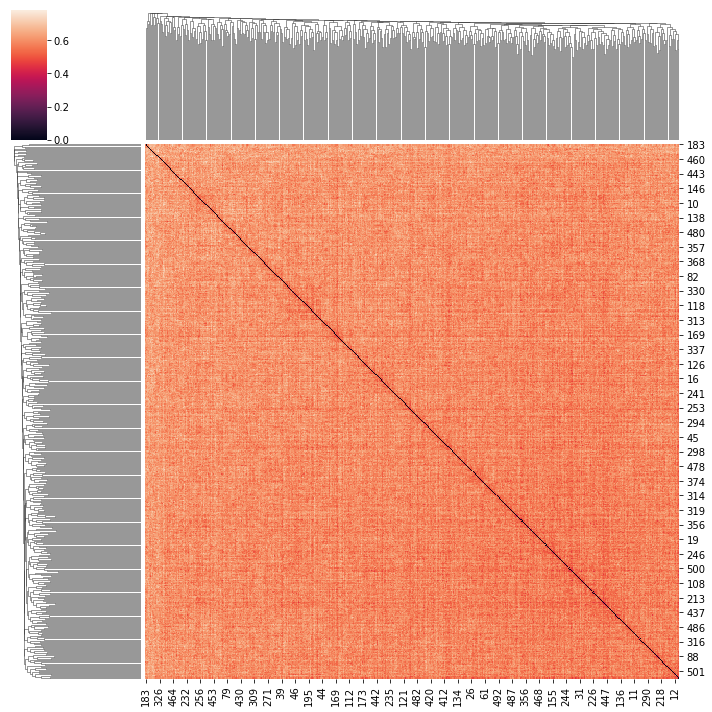

In [11]:
jac_res = jaccard_index(kmer_content, kmer_content, max_batch_size=512, dtype=torch.half)

DF_dism = 1 - jac_res.cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [12]:
with open('K562_tau_mh_samples.pkl', 'wb') as f:
    pickle.dump(mcmc_run['samples'][-1].cpu().numpy(), file=f)

In [34]:
mcmc_run['samples'][-1][seq_id].shape

torch.Size([4, 200])

In [4]:
def gradient_mh_step(seq, energy_fn, temperature=1.0):
    
    assert len(seq.shape) == 3
    old_seq = seq.detach().clone()
    old_seq.requires_grad = True
    old_energy = energy_fn(old_seq)
    old_logits = grad(old_energy.sum(), [old_seq])[0].detach()
    
    proposal_dist = dist.OneHotCategorical(logits=-old_logits.permute(0,2,1)/temperature)
    
    new_seq = proposal_dist.sample().permute(0,2,1).detach().clone()
    new_seq.requires_grad = True
    new_energy = energy_fn(new_seq)
    new_logits = grad(new_energy.sum(), [new_seq])[0].detach()
    
    reverse_dist  = dist.OneHotCategorical(logits=-new_logits.permute(0,2,1)/temperature)
    
    forward_energy = -proposal_dist.log_prob(new_seq.permute(0,2,1)).sum(-1)
    reverse_energy = -reverse_dist .log_prob(old_seq.permute(0,2,1)).sum(-1)
    
    u = torch.rand_like(old_energy).log()
    accept = u.le( old_energy + forward_energy - new_energy - reverse_energy )
    
    sample = torch.stack([old_seq, new_seq], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    energy = torch.stack([old_energy, new_energy], dim=0)[accept.long(),torch.arange(accept.numel())].detach().clone()
    
    return {'sample': sample.cpu(), 'energy': energy.cpu(), 'acceptance': accept.cpu()}

In [5]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=0, bias_alpha=1.)
step_count = 50000

In [6]:
test_insert = dist.OneHotCategorical(logits=torch.randn(3,200,4)).sample().permute(0,2,1)
test_insert.requires_grad = True
test_insert = test_insert.cuda()

In [7]:
mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for i in tqdm(range(step_count)):
    sample = gradient_mh_step(test_insert.cuda(), my_energy, 1.0)
    mcmc_run['samples'].append(sample['sample'])
    mcmc_run['energies'].append(sample['energy'])
    mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

100%|██████████| 50000/50000 [13:51<00:00, 60.15it/s]


In [8]:
mcmc_run['acceptances'].sum(0)

tensor([12714, 12682, 12719])

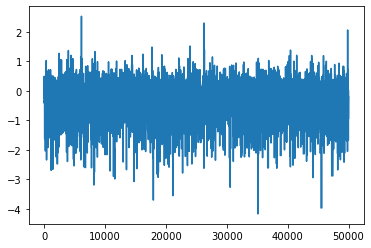

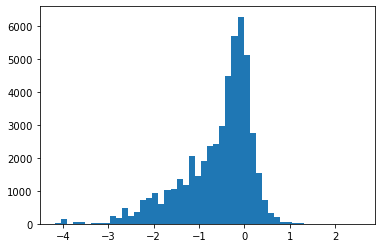

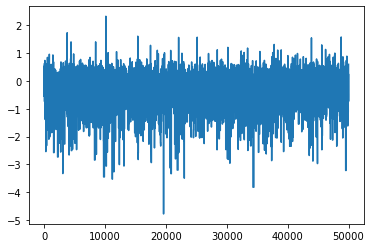

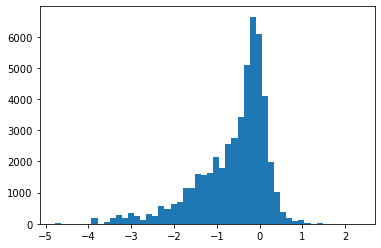

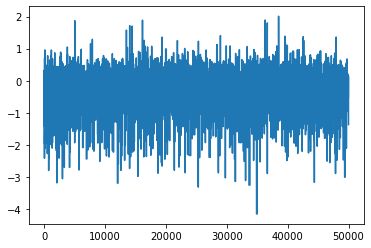

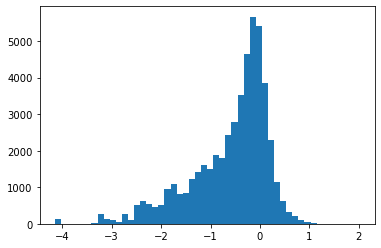

In [9]:
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,0])
plt.show()
plt.hist(mcmc_run['energies'][:,0].numpy(), bins=50)
plt.show()
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,1])
plt.show()
plt.hist(mcmc_run['energies'][:,1].numpy(), bins=50)
plt.show()
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,2])
plt.show()
plt.hist(mcmc_run['energies'][:,2].numpy(), bins=50)
plt.show()

In [10]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=0, bias_alpha=1.)

In [11]:
test_insert = dist.OneHotCategorical(logits=torch.randn(3,200,4)).sample().permute(0,2,1)
test_insert.requires_grad = True
test_insert = test_insert.cuda()

In [12]:
mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for i in tqdm(range(step_count)):
    sample = gradient_mh_step(test_insert.cuda(), my_energy, 0.5)
    mcmc_run['samples'].append(sample['sample'])
    mcmc_run['energies'].append(sample['energy'])
    mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

100%|██████████| 50000/50000 [13:45<00:00, 60.58it/s]


In [13]:
mcmc_run['acceptances'].sum(0)

tensor([4220, 3416, 3834])

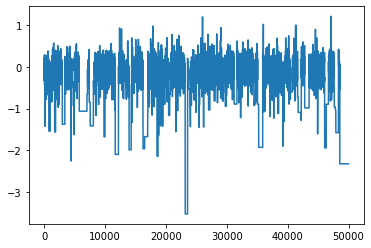

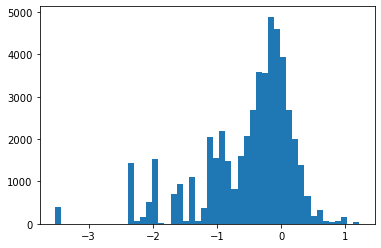

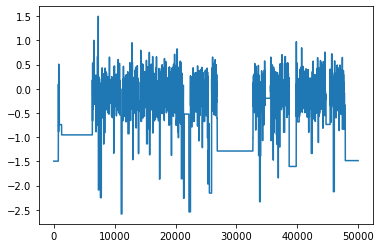

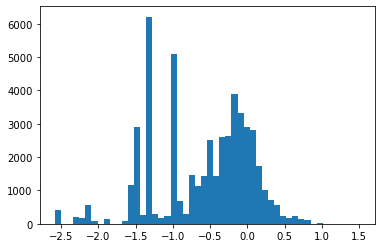

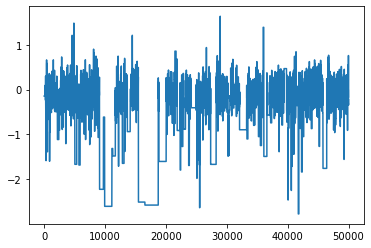

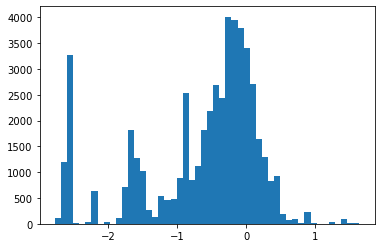

In [14]:
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,0])
plt.show()
plt.hist(mcmc_run['energies'][:,0].numpy(), bins=50)
plt.show()
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,1])
plt.show()
plt.hist(mcmc_run['energies'][:,1].numpy(), bins=50)
plt.show()
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,2])
plt.show()
plt.hist(mcmc_run['energies'][:,2].numpy(), bins=50)
plt.show()

In [15]:
mcmc_run['energies'][:,0].shape

torch.Size([50000])

In [16]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=0, bias_alpha=1.)

In [17]:
test_insert = dist.OneHotCategorical(logits=torch.randn(3,200,4)).sample().permute(0,2,1)
test_insert.requires_grad = True
test_insert = test_insert.cuda()

In [18]:
mcmc_run = {'samples':[], 'energies': [], 'acceptances': []}
for i in tqdm(range(step_count)):
    sample = gradient_mh_step(test_insert.cuda(), my_energy, 10.)
    mcmc_run['samples'].append(sample['sample'])
    mcmc_run['energies'].append(sample['energy'])
    mcmc_run['acceptances'].append(sample['acceptance'])
    test_insert = sample['sample']
    
mcmc_run = { k: torch.stack(v, dim=0) for k,v in mcmc_run.items() }

100%|██████████| 50000/50000 [13:25<00:00, 62.06it/s]


In [19]:
mcmc_run['acceptances'].sum(0)

tensor([33276, 33645, 32960])

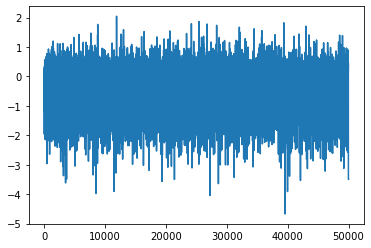

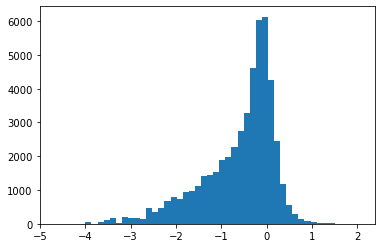

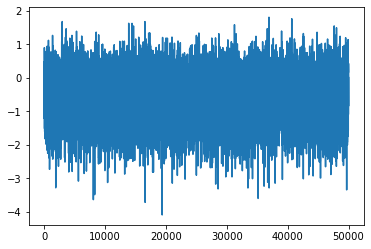

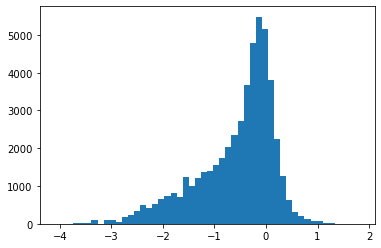

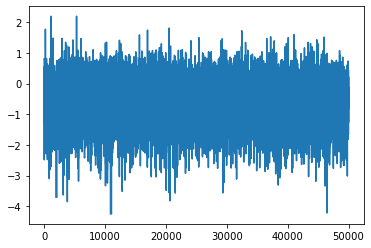

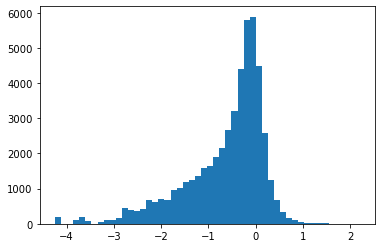

In [20]:
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,0])
plt.show()
plt.hist(mcmc_run['energies'][:,0].numpy(), bins=50)
plt.show()
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,1])
plt.show()
plt.hist(mcmc_run['energies'][:,1].numpy(), bins=50)
plt.show()
plt.plot(torch.arange(step_count),mcmc_run['energies'][:,2])
plt.show()
plt.hist(mcmc_run['energies'][:,2].numpy(), bins=50)
plt.show()

In [157]:
mcmc_run['energies'][:,0]

tensor([-0.0497, -0.0497, -0.0497,  ..., -0.0497, -0.0497, -0.0497])

In [124]:
((one_step['sample'] - test_insert).abs().sum(dim=1) > 0).sum(dim=-1)

tensor([  0, 136,   0], device='cuda:0')

In [ ]:
def compute_logits(energy, seq):
    de = grad(energy, [seq])[0].detach()
    de -= de * seq  # current state would result in no change
    return de.reshape(-1)

def mcmc_perturb(seq, temperature=1.0, num_steps=1):
    assert seq.shape == (200, 4)  # one-hot encoded position x nucleotide

    # Initialize.
    seq = seq.clone().requires_grad_()  # so we can use backprop
    old_energy = energy_fn(seq)
    assert old_energy.shape() == ()
    old_logits = compute_logits(old_energy, seq)
    assert old_logits.shape == (200, 4,)
    old_dist = None
    num_accepted = 0
    for step in range(num_steps):
        # Compute proposal dist if needed.
        if old_dist is None:
            # Use a linear approximation of the energy function as a proposal.
            old_dist = dist.Categorical(logits=old_logits / temperature)

        # Sample from proposal dist.
        proposal = proposal_dist.sample()
        new_seq = old_seq.detach().clone()
        new_seq
        new_energy = energy_fn(proposal)
        new_logits = compute_logits(new_energy, new_seq)

        # Perform Metropolis hastings.
        with torch.no_grad():
            mh_threshold = (
                old_energy - new_energy + old_logits - new_logits 
            ) / temperature
        u = torch.rand().clamp(min=1e-20)
        if u.log() <= mh_threshold:
            # accept
            seq = proposal.requires_grad_()
            old_energy = new_energy
            old_logits = new_logits
            porposal_dist = None  # request recomputation
            num_accepted += 1
    return {"sample": seq.detach(), "num_accepted": num_accepted}

In [ ]:
@torch.no_grad()
def gibbs_perturb(seq, temperature=1.0, num_steps=1):
    assert seq.shape == (200, 4)  # one-hot encoded position x nucleotide

    # Initialize.
    seq = seq.clone()
    old_energy = energy_fn(seq)
    assert old_energy.shape() == ()
    old_dist = None

    for step in range(num_steps):
        # Flip a random site.
        i = torch.randint(0, 200, ()).item()
        j = torch.randint(0, 4, ()).item()
        proposal = seq.clone()
        proposal[i] = 0
        proposal[i, j] = 1
        new_energy = energy_fn(proposal)
  
        # Perform Gibbs update.
        threshold = (old_energy - new_energy) / temperature
        u = torch.rand()
        if u.log() <= threshold:
            # accept
            seq = proposal
            old_energy = new_energy
    return seq